In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import numpy as np 
import pandas as pd 
import seaborn as sns

import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.model_selection import GridSearchCV, KFold, train_test_split, TimeSeriesSplit, StratifiedKFold, RandomizedSearchCV
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.metrics import confusion_matrix, f1_score, mean_absolute_error, make_scorer
import lightgbm as lgb
import xgboost as xgb
import catboost as cb
import statsmodels.api as sm
from sklearn.metrics import make_scorer
from statsmodels.regression.linear_model import OLS
from datetime import datetime
from sklearn.model_selection import cross_val_score
from sklearn.cluster import DBSCAN
import shap
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier


        
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/train_8wry4cB.csv
/kaggle/input/sample_submission_opxHi4g.csv
/kaggle/input/test_Yix80N0.csv


In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        if col != 'time':
            col_type = df[col].dtypes
            if col_type in numerics:
                c_min = df[col].min()
                c_max = df[col].max()
                if str(col_type)[:3] == 'int':
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)  
                else:
                    if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                        df[col] = df[col].astype(np.float16)
                    elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
train = pd.read_csv('../input/train_8wry4cB.csv')
test = pd.read_csv('../input/test_Yix80N0.csv')
submission = pd.read_csv('../input/sample_submission_opxHi4g.csv')
data = train.append(test, ignore_index=True,sort=False)

In [4]:
train.shape, test.shape, submission.shape, data.shape

((10500, 5), (4500, 4), (4500, 2), (15000, 5))

In [5]:
ff = lambda x: len(x["ProductList"].split("/;"))
data["number_of_products_viewed"] = data.apply(ff, axis=1)

In [6]:
v = pd.DataFrame(data.ProductList.str.split('/|/;', expand=True))
v.fillna(value = pd.np.nan, inplace=True)
v = v.replace(';', '', regex=True).replace(r'^\s*$', np.nan, regex=True).fillna(int(-999))

In [7]:
v.head()

,0,1,2,3,4,5,6,7,8,9,...,163,164,165,166,167,168,169,170,171,172
0,A00002,B00003,C00006,D28435,A00002,B00003,C00006,D02554,A00002,B00003,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999.0
1,A00001,B00009,C00031,D29404,A00001,B00009,C00031,D02617,A00001,B00009,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999.0
2,A00002,B00001,C00020,D16944,-999,-999,-999,-999,-999,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999.0
3,A00002,B00004,C00018,D10284,A00002,B00004,C00018,D10285,A00002,B00004,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999.0
4,A00001,B00001,C00012,D30805,A00001,B00001,C00012,D30806,-999,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999.0


In [8]:
v = v.drop(v.columns[2:173], axis = 1)

In [9]:
v.head()

,0,1
0,A00002,B00003
1,A00001,B00009
2,A00002,B00001
3,A00002,B00004
4,A00001,B00001


In [10]:
A_values = pd.DataFrame(v[0].value_counts())
A_values.head(10)

,0
A00002,9584
A00003,2316
A00001,2237
A00005,280
A00004,191
A00006,149
A00011,70
A00010,64
A00009,39
A00007,36


In [11]:
B_values = pd.DataFrame(v[1].value_counts().sort_values(ascending = False))
B_values.head(10)

,1
B00002,3490
B00001,2027
B00003,1958
B00012,1140
B00004,1048
B00007,882
B00009,501
B00022,472
B00005,413
B00015,352


In [12]:
data = pd.concat([data, v], axis= 1)

In [13]:
data['startTime'] = pd.to_datetime(data.startTime, format = '%d/%m/%y  %H:%M')
data['endTime'] = pd.to_datetime(data.endTime, format = '%d/%m/%y  %H:%M')

In [14]:
#parse timestamp as new features
data['start_month'] = data['startTime'].dt.month
data['start_day'] = data['startTime'].dt.day
data['start_hour'] = data['startTime'].dt.hour
data['start_minute'] = data['startTime'].dt.minute
data['start_dayofweek_num'] = data['startTime'].dt.dayofweek
data['start_dayofweek_name'] = data['startTime'].dt.weekday_name
# data['start_week_of_year'] = data['startTime'].dt.weekofyear

In [15]:
#parse timestamp as new features
data['end_month'] = data['endTime'].dt.month
data['end_day'] = data['endTime'].dt.day
data['end_hour'] = data['endTime'].dt.hour
data['end_minute'] = data['endTime'].dt.minute
data['end_dayofweek_num'] = data['endTime'].dt.dayofweek
data['end_dayofweek_name'] = data['endTime'].dt.weekday_name
# data['end_week_of_year'] = data['endTime'].dt.weekofyear

In [16]:
def weekend(x):
    if x.dayofweek == 5 or x.dayofweek == 6:
        return 1
    else:
        return 0 

data['start_weekend'] = data['startTime'].apply(weekend) 
data['end_weekend'] = data['endTime'].apply(weekend) 


In [17]:
# the time spent per one session
data['duration_in_sec'] = (data['endTime'] - data['startTime']).astype('timedelta64[s]') 

# average time per product
data['average_time_per_product_in_sec'] = data['duration_in_sec'] / data["number_of_products_viewed"]


In [18]:
ttt = data.ProductList.str.replace(';', '', regex=True)
ttt = ttt.str.split('/')
data['ProductList'] = ttt

In [19]:
# if start hour equals to end hour

def view_period(df):
    if df['start_minute'] == df['end_minute']:
        return 1
    else:
        return 0
    
data['finish_viewing_at_the_same_minute'] = data.apply(view_period, axis = 1)

In [20]:
import re

data['A00001'] = data['ProductList'].apply(lambda x: re.findall('A00001', str(x)))
data['A00001_count'] = data['A00001'].apply(lambda x: len(x))

data['A00002'] = data['ProductList'].apply(lambda x: re.findall('A00002', str(x)))
data['A00002_count'] = data['A00002'].apply(lambda x: len(x))

data['A00003'] = data['ProductList'].apply(lambda x: re.findall('A00003', str(x)))
data['A00003_count'] = data['A00003'].apply(lambda x: len(x))

data['A00004'] = data['ProductList'].apply(lambda x: re.findall('A00004', str(x)))
data['A00004_count'] = data['A00004'].apply(lambda x: len(x))

data['A00005'] = data['ProductList'].apply(lambda x: re.findall('A00005', str(x)))
data['A00005_count'] = data['A00005'].apply(lambda x: len(x))

data['A00006'] = data['ProductList'].apply(lambda x: re.findall('A00006', str(x)))
data['A00006_count'] = data['A00006'].apply(lambda x: len(x))

data['A00007'] = data['ProductList'].apply(lambda x: re.findall('A00007', str(x)))
data['A00007_count'] = data['A00007'].apply(lambda x: len(x))

data['A00008'] = data['ProductList'].apply(lambda x: re.findall('A00008', str(x)))
data['A00008_count'] = data['A00008'].apply(lambda x: len(x))

data['A00009'] = data['ProductList'].apply(lambda x: re.findall('A00009', str(x)))
data['A00009_count'] = data['A00009'].apply(lambda x: len(x))

data['A00010'] = data['ProductList'].apply(lambda x: re.findall('A00010', str(x)))
data['A00010_count'] = data['A00010'].apply(lambda x: len(x))

data['A00011'] = data['ProductList'].apply(lambda x: re.findall('A00011', str(x)))
data['A00011_count'] = data['A00011'].apply(lambda x: len(x))

In [21]:
import re

data['B00001'] = data['ProductList'].apply(lambda x: re.findall('B00001', str(x)))
data['B00001_count'] = data['B00001'].apply(lambda x: len(x))

data['B00002'] = data['ProductList'].apply(lambda x: re.findall('B00002', str(x)))
data['B00002_count'] = data['B00002'].apply(lambda x: len(x))

data['B00003'] = data['ProductList'].apply(lambda x: re.findall('B00003', str(x)))
data['B00003_count'] = data['B00003'].apply(lambda x: len(x))

data['B00004'] = data['ProductList'].apply(lambda x: re.findall('B00004', str(x)))
data['B00004_count'] = data['B00004'].apply(lambda x: len(x))

data['B00007'] = data['ProductList'].apply(lambda x: re.findall('B00007', str(x)))
data['B00007_count'] = data['B00007'].apply(lambda x: len(x))

data['B00012'] = data['ProductList'].apply(lambda x: re.findall('B00012', str(x)))
data['B00012_count'] = data['B00012'].apply(lambda x: len(x))

In [22]:
data = data.drop(['A00001', 'A00002', 'A00003', 'A00004', 'A00005', 'A00006', 'A00007', 'A00008', 'A00009','A00010', 'A00011','B00001', 'B00002', 'B00003', 'B00004', 'B00007', 'B00012'], axis = 1)

In [23]:
data.head()

,session_id,startTime,endTime,ProductList,gender,number_of_products_viewed,0,1,start_month,start_day,...,A00008_count,A00009_count,A00010_count,A00011_count,B00001_count,B00002_count,B00003_count,B00004_count,B00007_count,B00012_count
0,u16159,2014-12-15 18:11:00,2014-12-15 18:12:00,"[A00002, B00003, C00006, D28435, A00002, B0000...",female,4,A00002,B00003,12,15,...,0,0,0,0,0,0,4,0,0,0
1,u10253,2014-12-16 14:35:00,2014-12-16 14:41:00,"[A00001, B00009, C00031, D29404, A00001, B0000...",male,7,A00001,B00009,12,16,...,0,0,0,0,0,0,0,0,0,0
2,u19037,2014-12-01 15:58:00,2014-12-01 15:58:00,"[A00002, B00001, C00020, D16944, ]",female,1,A00002,B00001,12,1,...,0,0,0,0,1,0,0,0,0,0
3,u14556,2014-11-23 02:57:00,2014-11-23 03:00:00,"[A00002, B00004, C00018, D10284, A00002, B0000...",female,3,A00002,B00004,11,23,...,0,0,0,0,0,0,0,3,0,0
4,u24295,2014-12-17 16:44:00,2014-12-17 16:46:00,"[A00001, B00001, C00012, D30805, A00001, B0000...",male,2,A00001,B00001,12,17,...,0,0,0,0,2,0,0,0,0,0


In [24]:
le = LabelEncoder()

# for col in ['start_dayofweek_name', 'end_dayofweek_name', 'gender']:
data['start_dayofweek_name'] = le.fit_transform(data['start_dayofweek_name'])
data['end_dayofweek_name'] = le.fit_transform(data['end_dayofweek_name'])
data['session_id'] = le.fit_transform(data['session_id'])
data.iloc[:, 7] = le.fit_transform(data.iloc[:, 7])

In [25]:
data['gender'] = [1 if x == 'female' else 0 for x in data['gender']]

In [26]:
data = data.drop(['startTime', 'endTime', 'ProductList'], axis = 1)
y_1 = data['gender']
X_1 = data.drop(['gender'], axis = 1)

In [27]:
X_1.head()

,session_id,number_of_products_viewed,0,1,start_month,start_day,start_hour,start_minute,start_dayofweek_num,start_dayofweek_name,...,A00008_count,A00009_count,A00010_count,A00011_count,B00001_count,B00002_count,B00003_count,B00004_count,B00007_count,B00012_count
0,6158,4,A00002,2,12,15,18,11,0,1,...,0,0,0,0,0,0,4,0,0,0
1,252,7,A00001,8,12,16,14,35,1,5,...,0,0,0,0,0,0,0,0,0,0
2,9036,1,A00002,0,12,1,15,58,0,1,...,0,0,0,0,1,0,0,0,0,0
3,4555,3,A00002,3,11,23,2,57,6,3,...,0,0,0,0,0,0,0,3,0,0
4,14294,2,A00001,0,12,17,16,44,2,6,...,0,0,0,0,2,0,0,0,0,0


In [28]:
train_predictors = X_1.select_dtypes('object')
one_hot_encoded_training_predictors = pd.get_dummies(train_predictors)

In [29]:
X_1_encoded =  pd.concat([X_1, one_hot_encoded_training_predictors], axis=1)

In [30]:
X_1_encoded.head()

,session_id,number_of_products_viewed,0,1,start_month,start_day,start_hour,start_minute,start_dayofweek_num,start_dayofweek_name,...,0_A00002,0_A00003,0_A00004,0_A00005,0_A00006,0_A00007,0_A00008,0_A00009,0_A00010,0_A00011
0,6158,4,A00002,2,12,15,18,11,0,1,...,1,0,0,0,0,0,0,0,0,0
1,252,7,A00001,8,12,16,14,35,1,5,...,0,0,0,0,0,0,0,0,0,0
2,9036,1,A00002,0,12,1,15,58,0,1,...,1,0,0,0,0,0,0,0,0,0
3,4555,3,A00002,3,11,23,2,57,6,3,...,1,0,0,0,0,0,0,0,0,0
4,14294,2,A00001,0,12,17,16,44,2,6,...,0,0,0,0,0,0,0,0,0,0


In [31]:
X_1_encoded = X_1_encoded.drop(X_1_encoded.columns[2], axis = 1)

In [32]:
X, y = X_1_encoded[:10500], y_1[:10500]
X_test = X_1_encoded[10500:]

In [ ]:
categorical_features_indices = np.where(X.dtypes == 'object')[0]

In [33]:
X = reduce_mem_usage(X)

Mem. usage decreased to  0.55 Mb (82.1% reduction)



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<h3> Clustering

In [ ]:
from sklearn.cluster import KMeans

X = X
X_test = X_test

km = KMeans(init='random', n_clusters = 2)
km.fit(X)
    
X['km'] = km.labels_
X_test['km'] = km.predict(X_test)

In [ ]:
X_test.km.value_counts()

<h3> Oversampling SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler

In [ ]:
from collections import Counter
print('Original dataset shape {}'.format(Counter(y)))

In [ ]:
over = SMOTE(sampling_strategy=0.5)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
X, y = pipeline.fit_resample(X, y)

In [ ]:
from collections import Counter
print('New dataset shape {}'.format(Counter(y)))

<h3> Train test split

In [34]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.3)

In [35]:
sk = StratifiedKFold(n_splits = 5)

In [37]:
%%time

params = {'loss_function':'Logloss', 
          'eval_metric':'Accuracy', 
           'verbose': 200,
#            'cat_features': categorical_features_indices,  
          'random_seed': 1,
          'iterations' : 2000,
          'learning_rate': 0.07,
          'depth' : 6
          
#           'task_type' : 'GPU'
#            'border_count': 32
         }

model = cb.CatBoostClassifier(**params)

model.fit(X_train, y_train, 
          eval_set=(X_valid, y_valid), 
          use_best_model=True,
          plot=True 
         );

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8670748	test: 0.8552381	best: 0.8552381 (0)	total: 64.6ms	remaining: 2m 9s
200:	learn: 0.8995918	test: 0.8780952	best: 0.8780952 (198)	total: 1.27s	remaining: 11.3s
400:	learn: 0.9183673	test: 0.8819048	best: 0.8834921 (388)	total: 2.77s	remaining: 11s
600:	learn: 0.9389116	test: 0.8869841	best: 0.8879365 (583)	total: 4.2s	remaining: 9.77s
800:	learn: 0.9534694	test: 0.8892063	best: 0.8892063 (797)	total: 5.49s	remaining: 8.21s
1000:	learn: 0.9644898	test: 0.8901587	best: 0.8904762 (915)	total: 6.79s	remaining: 6.77s
1200:	learn: 0.9723810	test: 0.8876190	best: 0.8904762 (915)	total: 8.1s	remaining: 5.39s
1400:	learn: 0.9786395	test: 0.8879365	best: 0.8904762 (915)	total: 9.41s	remaining: 4.02s
1600:	learn: 0.9847619	test: 0.8882540	best: 0.8904762 (915)	total: 10.9s	remaining: 2.71s
1800:	learn: 0.9873469	test: 0.8885714	best: 0.8904762 (915)	total: 12.2s	remaining: 1.35s
1999:	learn: 0.9902041	test: 0.8879365	best: 0.8904762 (915)	total: 14s	remaining: 0us

bestTest = 0.8

In [ ]:
y_preds = model.predict(X_test)

In [ ]:
submission['gender'] = y_preds
submission['gender'] = submission['gender'].apply(lambda x: 'female' if x == 1 else 'male')

In [ ]:
submission.to_csv('janata_sub.csv', index = False)

<h3>Feature importance and shap values

In [38]:
feature_importance_df = model.get_feature_importance(prettified=True)

In [39]:
feature_importance_df.columns

Index(['Feature Id', 'Importances'], dtype='object')

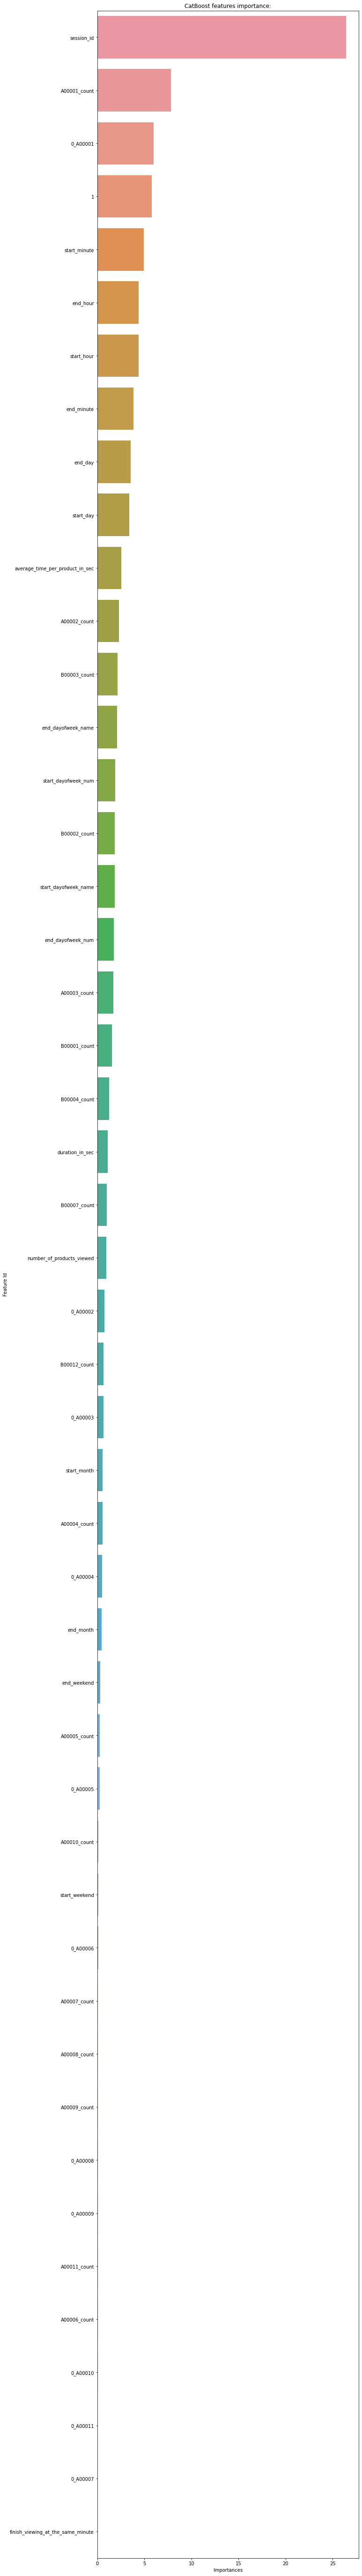

In [40]:
from matplotlib import pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 100));
sns.barplot(x="Importances", y="Feature Id", data=feature_importance_df);
plt.title('CatBoost features importance:');

In [41]:
from catboost import Pool

train_data = Pool(data=X_train,
                  label=y_train
#                   cat_features=categorical_features_indices
                 )
import shap
explainer = shap.TreeExplainer(model) # insert your model
shap_values = explainer.shap_values(train_data) 

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


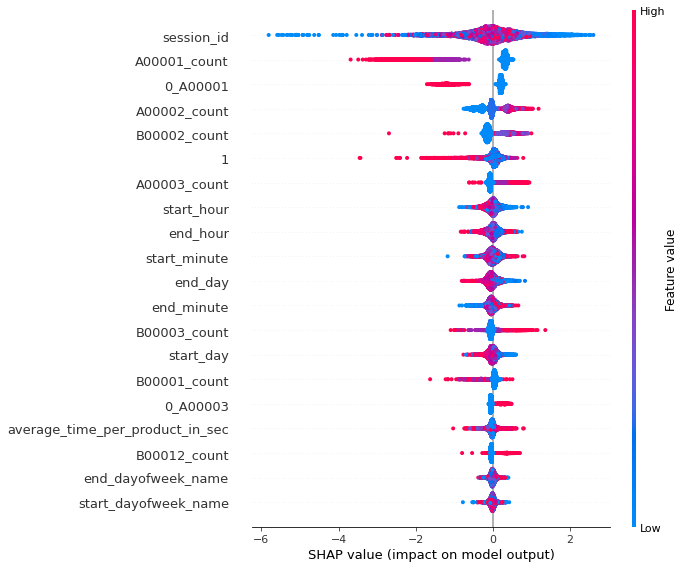

In [42]:
shap.summary_plot(shap_values, X_train)

<h3>  Cross val

In [ ]:
n_fold = 5 # amount of data folds
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=1)

params = {'loss_function':'Logloss', # objective function
          'eval_metric':'Accuracy', # metric
          'verbose': 200,
#           'cat_features': 
          'random_seed': 1,
          'iterations' : 2000,
           'use_best_model' : True,
           'depth':7,
            'learning_rate':0.03
#           'task_type' : 'GPU',
#           'border_count': 32
         }

test_data = Pool(data=X_test)
#                   cat_features=categorical_features_indices)

scores = []
prediction = np.zeros(X_test.shape[0])
for fold_n, (train_index, valid_index) in enumerate(folds.split(X, y)):
    
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index] # train and validation data splits
    y_train, y_valid = y[train_index], y[valid_index]
    
    train_data = Pool(data=X_train, 
                      label=y_train)
#                       cat_features=categorical_features_indices)
    valid_data = Pool(data=X_valid, 
                      label=y_valid)
#                       cat_features=categorical_features_indices)
    
    model = cb.CatBoostClassifier(**params)
    model.fit(train_data,
              eval_set=valid_data, 
              use_best_model=True
             )
    
    score = model.get_best_score()['validation']['Accuracy']
    scores.append(score)

    y_pred = model.predict_proba(test_data)[:, 1]
    prediction += y_pred

prediction /= n_fold
print('CV mean: {:.4f}, CV std: {:.4f}'.format(np.mean(scores), np.std(scores)))

In [ ]:
predictions = [1 if x > 0.6 else 0 for x in prediction]

In [ ]:
sns.distplot(prediction)

In [ ]:
submission['gender'] = predictions
submission['gender'] = submission['gender'].apply(lambda x: 'female' if x == 1 else 'male')
submission.to_csv('janata_sub.csv', index = False)

<h3> Random Forest

In [ ]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))
        
param_grid = {
    'max_depth': [10, 20, 30, 40, 50],
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_leaf': [1, 3, 5, 10, 15],
    'min_samples_split': [5, 10, 15, 20],
    'n_estimators': [50, 100, 200, 300]
            }

rf = RandomForestClassifier()

skf = StratifiedKFold(n_splits = 3, random_state = 1, shuffle = True)

random_search = RandomizedSearchCV(estimator = rf, param_distributions = param_grid, n_iter = 200,
                          cv = skf, n_jobs = -1, verbose = 2, random_state = 42)

start_time = timer(None) 
random_search.fit(X, y)
timer(start_time) 

In [ ]:
model = random_search.best_estimator_

In [ ]:
model = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
skf = StratifiedKFold(n_splits = 7, random_state = 1, shuffle = True)

In [ ]:
scores = cross_val_score(model, X, y, scoring = 'accuracy', cv = skf)
print(f'Cross-validation scores: {scores}')

print(scores.mean())

In [ ]:
y_preds = model.predict(X_test)

In [ ]:
submission['gender'] = y_preds
submission['gender'] = submission['gender'].apply(lambda x: 'female' if x == 1 else 'male')
submission.to_csv('janata_sub.csv', index = False)

<h3> LightGBM

In [ ]:
skf = StratifiedKFold(n_splits = 5, random_state = 1, shuffle = True)

In [ ]:
gridParams = {
    'learning_rate': [0.01, 0.05, 0.07, 0.1],
    'num_leaves': [90, 100, 150],
    'boosting_type' : ['gbdt'],
    'objective' : ['binary'],
    'max_depth' : [8,10,12],
    'random_state' : [501], 
    'colsample_bytree' : [0.5, 0.7, 0.9, 1],
    'subsample' : [0.5,0.7,0.9],
    'min_split_gain' : [0.01],
    'min_data_in_leaf':[10],
    'metric':['accuracy'],
    'n_estimators' : [100, 200, 300]
    }

In [ ]:
clf = lgb.LGBMClassifier()
grid = RandomizedSearchCV(clf, gridParams, verbose=1, cv=skf, n_jobs = -1, n_iter=100)
grid.fit(X,y)

In [ ]:
model = grid.best_estimator_

In [ ]:
model = lgb.LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.9,
               importance_type='split', learning_rate=0.1, max_depth=8,
               metric='accuracy', min_child_samples=20, min_child_weight=0.001,
               min_data_in_leaf=10, min_split_gain=0.01, n_estimators=300,
               n_jobs=-1, num_leaves=150, objective='binary', random_state=501,
               reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=0.5,
               subsample_for_bin=200000, subsample_freq=0)

In [ ]:
scores = cross_val_score(model, X, y, scoring = 'accuracy', cv = skf)
print(f'Cross-validation scores: {scores}')

print(scores.mean())

In [ ]:
model.fit(X, y)

In [ ]:
y_preds = model.predict(X_test)

In [ ]:
submission['gender'] = y_preds
submission['gender'] = submission['gender'].apply(lambda x: 'female' if x == 1 else 'male')
submission.to_csv('janata_sub.csv', index = False)

<h3> XGB

In [ ]:
# A parameter grid for XGBoost
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.4, 0.6, 0.8],
        'max_depth': [5, 7, 9],
        'learning_rate': [0.03, 0.01],
        'n_estimators': [1000, 1200]
        }

model = xgb.XGBClassifier(objective='binary:logistic',
                    silent=True, nthread=1, tree_method='gpu_hist', gpu_id=0)

In [ ]:
folds = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)


In [ ]:
param_comb = 40


random_search = RandomizedSearchCV(model, param_distributions=params, n_iter=param_comb, scoring='accuracy', n_jobs=4, cv=skf, verbose=3, random_state=1001)

# Here we go
start_time = timer(None) # timing starts from this point for "start_time" variable
random_search.fit(X, y)
timer(start_time) # timing ends here for "start_time" variable

In [ ]:
model = random_search.best_estimator_

In [ ]:
model = xgb.XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, gamma=0.5, gpu_id=0,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.03, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=1200, n_jobs=1, nthread=1, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, silent=True, subsample=0.8,
              tree_method='gpu_hist', validate_parameters=False,
              verbosity=None)

In [ ]:
scores = cross_val_score(model, X, y, scoring = 'accuracy', cv = skf)
print(f'Cross-validation scores: {scores}')

print(scores.mean())

In [ ]:
y_preds = model.predict(X_test)

In [ ]:
submission['gender'] = y_preds
submission['gender'] = submission['gender'].apply(lambda x: 'female' if x == 1 else 'male')
submission.to_csv('janata_sub.csv', index = False)

<h3> Stacking

In [ ]:
from sklearn.model_selection import cross_val_score, cross_val_predict

In [ ]:
rf = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

X_train_meta_rf = cross_val_predict(rf, X, y, cv = 5, method = 'predict_proba')
rf.fit(X, y)
X_test_meta_rf = rf.predict_proba(X_test)

In [ ]:
X_test_meta_rf.shape

In [ ]:
xg = xgb.XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, gamma=0.5, gpu_id=0,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.03, max_delta_step=0, max_depth=9,
              min_child_weight=1, monotone_constraints=None,
              n_estimators=1200, n_jobs=1, nthread=1, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, silent=True, subsample=0.8,
              tree_method='gpu_hist', validate_parameters=False,
              verbosity=None)
X_train_meta_xgb = cross_val_predict(xg, X, y, cv = 5, method = 'predict_proba')
xg.fit(X, y)
X_test_meta_xgb = xg.predict_proba(X_test)

In [ ]:
X_test_meta_xgb.shape

In [ ]:
params = {'loss_function':'Logloss', # objective function
          'eval_metric':'Accuracy', # metric
           'verbose': 200,
#            'cat_features': categorical_features_indices,  # output to stdout info about training process every 200 iterations
          'random_seed': 1,
          'iterations' : 2000,
          'learning_rate': 0.07,
          'depth' : 6
          
#           'task_type' : 'GPU'
#            'border_count': 32
         }
ct = cb.CatBoostClassifier(**params)

X_train_meta_cb = cross_val_predict(ct, X, y, cv = 3, method = 'predict_proba')

ct.fit(X,y,
          use_best_model=True, # True if we don't want to save trees created after iteration with the best validation score
          plot=True # True for visualization of the training process (it is not shown in a published kernel - try executing this code)
         );

X_test_meta_cb = ct.predict_proba(X_test)

In [ ]:
X_train_meta = pd.DataFrame([X_train_meta_rf[:,1], X_train_meta_xgb[:, 1], X_train_meta_cb[:, 1]]).transpose()
X_train_meta = pd.concat([X, X_train_meta], axis = 1)

In [ ]:
X_test_meta = pd.DataFrame([X_test_meta_rf[:,1], X_test_meta_xgb[:, 1], X_test_meta_cb[:, 1]]).transpose()
X_test_meta = pd.concat([X_test.reset_index(drop = True), X_test_meta], axis = 1)

In [ ]:
# lgbm classifier for stacking model
model = lgb.LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.9,
               importance_type='split', learning_rate=0.07, max_depth=10,
               metric='accuracy', min_child_samples=20, min_child_weight=0.001,
               min_data_in_leaf=10, min_split_gain=0.01, n_estimators=300,
               n_jobs=-1, num_leaves=150, objective='binary', random_state=501,
               reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=0.5,
               subsample_for_bin=200000, subsample_freq=0)

model.fit(X_train_meta, y)
y_preds = model.predict(X_test_meta)

In [ ]:
submission['gender'] = y_preds
submission['gender'] = submission['gender'].apply(lambda x: 'female' if x == 1 else 'male')
submission.to_csv('janata_sub.csv', index = False)